In [1]:
import numpy as np
import pandas as pd
from math import floor
mouthday={1:31,2:31,3:28,4:31,5:30,6:31,7:30,8:31,9:31,10:30,11:31,12:30}
def solvetimediff(t2, t1):#这个函数只要在同一个月份就可以计算很正确
    t1sec = t1 % 100
    t2sec = t2 % 100
    t1 = floor(t1 / 100)
    t2 = floor(t2 / 100)
    t1min = t1 % 100
    t2min = t2 % 100
    t1 = floor(t1 / 100)
    t2 = floor(t2 / 100)
    t1hour = t1 % 100
    t2hour = t2 % 100
    t1 = floor(t1 / 100)
    t2 = floor(t2 / 100)
    t1day = t1 % 100
    t2day = t2 % 100
    t1 = floor(t1 / 100)
    t2 = floor(t2 / 100)
    t1mth = t1 % 100
    t2mth = t2 % 100
    if t2sec < t1sec:
        t2min = t2min - 1
        t3sec = t2sec + 60 - t1sec
    else:
        t3sec = t2sec - t1sec
    if t2min < t1min:
        t2hour = t2hour - 1
        t3min = t2min + 60 - t1min
    else:
        t3min = t2min - t1min
    if t2hour < t1hour:
        t2day = t2day - 1
        t3hour = t2hour + 24 - t1hour
    else:
        t3hour = t2hour - t1hour
    if t2day < t1day:
        t2mth = t2mth - 1
        t3day = t2day + mouthday[t2mth] - t1day
    else:
        t3day = t2day - t1day
    return t3sec+t3min*60+t3hour*3600+t3day*86400

In [2]:
train_data_bycar=[]
clear_train_data_path=r"C:\Users\14020\Desktop\NCBDC 2019\Clear_TrainData"
clear_train_data_csvname=["Vehicle No.0.csv","Vehicle No.1.csv","Vehicle No.2.csv","Vehicle No.3.csv","Vehicle No.4.csv"]
for num in range(5):
    train_data_bycar.append(pd.read_csv(clear_train_data_path+'\\'+clear_train_data_csvname[num]).drop(['Unnamed: 10'],axis=1))

In [3]:
#1 4 7 11分开
train_data_bycar_mouth=[]
for df in train_data_bycar:
    df1=df.loc[df.time>20170000000000].loc[df.time<20180200000000]
    df2=df.loc[df.time>20180200000000].loc[df.time<20180500000000]
    df3=df.loc[df.time>20180500000000].loc[df.time<20180800000000]
    df4=df.loc[df.time>20181000000000].loc[df.time<20190000000000]
    train_data_bycar_mouth.append(df1)
    train_data_bycar_mouth.append(df2)
    train_data_bycar_mouth.append(df3)
    train_data_bycar_mouth.append(df4)

In [4]:
#用来增加secdiff和
def addsecmilediff(df):
    timediff = []
    time = df.time.tolist()
    for index, t in enumerate(time):
        if(t==time[0]):
            timediff.append(0)
            continue
        timediff.append(solvetimediff(t,time[index-1]))
    #print(timediff)
    df['secdiff']=timediff
    df['milediff']=df['mileage'].diff()
    return df

In [5]:
continueTimedata=[]
for data in train_data_bycar_mouth:
    data=addsecmilediff(data)
    cutpoint=data.loc[data.secdiff>100].loc[data.milediff>1].index
    section=[]
    for index,i in enumerate(cutpoint):
        if index==0:
            section.append([0,cutpoint[0]-1])
        else:
            section.append([cutpoint[index-1],i-1])
        if i==cutpoint[-1]:
            section.append([i,len(data)-1])
    timediff=[]
    for i in section:
        if i[1]-i[0]>10:
            timediff.append(i)
    #print(timediff)
    for p in timediff:
        continueTimedata.append(data.loc[p[0]:p[1]])

In [14]:
from scipy.interpolate import lagrange
def interp_lagrange(data,p,k=3):#我就看了一些时间差过长但是里程差小于0.3的数据 soc是没有变化的 所以我拉格朗日插值的时候选取前后3个数据作为基函数
    # 调用拉格朗日插值，得到插值函数p
    num=int(data.loc[p].secdiff/10-1)
    index=np.hstack((np.array([i+p-k for i in range(k)]),np.array([i+p+1 for i in range(k)])))
    x=np.hstack((np.array([i for i in range(k)]),np.array([i for i in range(k+num,2*k+num)])))
    xx=np.array([i for i in range(k,k+num)])
    indexdata=data.loc[index]
    #p
    speedp = lagrange(x,indexdata.speed.to_numpy())
    total_voltagep=lagrange(x,indexdata.total_voltage.to_numpy())
    total_currentp=lagrange(x,indexdata.total_current.to_numpy())
    socp=lagrange(x,indexdata.soc.to_numpy())
    temp_maxp=lagrange(x,indexdata.temp_max.to_numpy())
    temp_minp=lagrange(x,indexdata.temp_min.to_numpy())
    motor_voltagep=lagrange(x,indexdata.motor_voltage.to_numpy())
    motor_currentp=lagrange(x,indexdata.motor_current.to_numpy())
    mileagep=lagrange(x,indexdata.mileage.to_numpy())
    milediffp=lagrange(x,indexdata.milediff.to_numpy())
    #secdiff 不用 10s
    #predict
    #yy = p(xx)
    new=pd.DataFrame(columns=data.columns)
    
    for i in range(num):
        new.loc[i]=[20180000000000,speedp(xx)[i],total_voltagep(xx)[i],total_currentp(xx)[i],socp(xx)[i],temp_maxp(xx)[i],temp_minp(xx)[i],motor_voltagep(xx)[i],motor_currentp(xx)[i],mileagep(xx)[i],10,0]
    print(num,p,index,x,xx,indexdata,new)
    if len(data)==p:
        data=pd.concat([data.loc[0:p-1],new],ignore_index=True)
    else:
        data=pd.concat([data.loc[0:p-1],new,data.loc[p:]],ignore_index=True)
    data['milediff']=data.mileage.diff()
    return data
number=0
data=continueTimedata[0]

sizeofcutP=len(data.loc[data.secdiff<100].loc[data.secdiff>=20].index)
cutpoint=data.loc[data.secdiff<100].loc[data.secdiff>=20].index[-1]
interp_lagrange(data,cutpoint,k=0)

6 18623 [] [] [0 1 2 3 4 5] Empty DataFrame
Columns: [time, speed, total_voltage, total_current, soc, temp_max, temp_min, motor_voltage, motor_current, mileage, secdiff, milediff]
Index: []            time  speed  total_voltage  total_current  soc  temp_max  temp_min  \
0  2.018000e+13    0.0            0.0            0.0  0.0       0.0       0.0   
1  2.018000e+13    0.0            0.0            0.0  0.0       0.0       0.0   
2  2.018000e+13    0.0            0.0            0.0  0.0       0.0       0.0   
3  2.018000e+13    0.0            0.0            0.0  0.0       0.0       0.0   
4  2.018000e+13    0.0            0.0            0.0  0.0       0.0       0.0   
5  2.018000e+13    0.0            0.0            0.0  0.0       0.0       0.0   

   motor_voltage  motor_current  mileage  secdiff  milediff  
0            0.0            0.0      0.0     10.0       0.0  
1            0.0            0.0      0.0     10.0       0.0  
2            0.0            0.0      0.0     10.0       

,time,speed,total_voltage,total_current,soc,temp_max,temp_min,motor_voltage,motor_current,mileage,secdiff,milediff
0,2.018010e+13,0.0,539.1,-19.0,46.0,32.0,21.0,0.0,0.0,33892.0,0.0,NaN
1,2.018010e+13,0.0,539.1,-19.0,46.0,32.0,21.0,0.0,0.0,33892.0,10.0,0.0
2,2.018010e+13,0.0,539.1,-19.0,46.0,32.0,21.0,0.0,0.0,33892.0,10.0,0.0
3,2.018010e+13,0.0,539.1,-19.0,46.0,32.0,21.0,0.0,0.0,33892.0,10.0,0.0
4,2.018010e+13,0.0,539.1,-19.0,46.0,32.0,21.0,0.0,0.0,33892.0,10.0,0.0
5,2.018010e+13,0.0,539.1,-19.0,46.0,32.0,21.0,0.0,0.0,33892.0,10.0,0.0
6,2.018010e+13,0.0,539.1,-19.0,46.0,32.0,21.0,0.0,0.0,33892.0,10.0,0.0
7,2.018010e+13,0.0,539.1,-19.0,46.0,32.0,21.0,0.0,0.0,33892.0,10.0,0.0
8,2.018010e+13,0.0,539.1,-19.0,46.0,32.0,21.0,0.0,0.0,33892.0,10.0,0.0
9,2.018010e+13,0.0,539.1,-19.0,46.0,32.0,21.0,0.0,0.0,33892.0,10.0,0.0


In [14]:
for number,data in enumerate(continueTimedata):
    sizeofcutP=len(data.loc[data.secdiff<100].loc[data.secdiff>=20].index)
    for i in range(sizeofcutP):
        cutpoint=data.loc[data.secdiff<100].loc[data.secdiff>=20].index[i]
        data=interp_lagrange(data,cutpoint,k=1)
    data.to_csv(r"C:\Users\14020\Desktop\NCBDC 2019\continueTimedata"+'\\'+str(number)+".csv")

In [281]:
data.loc[int(p/10)*10:int(p/10)*10+20]

#speed,total_voltage,total_current,soc,temp_max,temp_min,motor_voltage,motor_current,mileage,secdiff=10milediff

,time,speed,total_voltage,total_current,soc,temp_max,temp_min,motor_voltage,motor_current,mileage,secdiff,milediff
6310,20180102140451,42.0,533.5,23.0,84.0,23.0,16.0,533.0,30.0,34021.6,10,0.1
6311,20180102140501,38.0,535.9,-11.0,84.0,23.0,16.0,536.0,-14.0,34021.7,10,0.1
6312,20180102140511,15.0,540.6,-62.0,84.0,23.0,16.0,541.0,-54.0,34021.8,10,0.1
6313,20180102140521,0.0,537.2,1.0,84.0,23.0,16.0,537.0,0.0,34021.8,10,0.0
6314,20180102140531,0.0,537.1,1.0,84.0,23.0,16.0,537.0,0.0,34021.8,10,0.0
6315,20180102140541,14.0,532.9,73.0,84.0,23.0,16.0,531.0,99.0,34021.8,10,0.0
6316,20180102140601,42.0,531.5,54.0,84.0,23.0,16.0,531.0,58.0,34022.0,20,0.2
6317,20180102140611,42.0,533.7,20.0,83.0,23.0,16.0,536.0,-6.0,34022.1,10,0.1
6318,20180102140631,33.0,526.6,180.0,83.0,23.0,16.0,527.0,156.0,34022.3,20,0.2
6319,20180102140701,42.0,534.4,12.0,83.0,23.0,16.0,534.0,19.0,34022.6,30,0.3


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

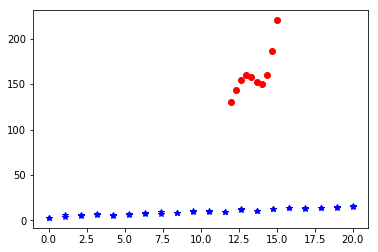

In [208]:

import numpy as np
import matplotlib.pyplot as plt


def interp_lagrange(x, y, xx):
    # 调用拉格朗日插值，得到插值函数p
    p = lagrange(x, y)
    yy = p(xx)
    plt.plot(x, y, "b*")
    plt.plot(xx, yy, "ro")
    plt.show()



NUMBER = 20
eps1 = np.random.rand(NUMBER) * 2
eps2 = np.random.rand(NUMBER) * 3
# 构造样本数据
x = np.linspace(0, 20, NUMBER)
y1 = np.linspace(2, 14, NUMBER) + eps1
y2 = np.linspace(2, 14, NUMBER) + eps2
y=np.hstack((y1.reshape([len(y1),1]),y2.reshape([len(y2),1])))
xx = np.linspace(12, 15, 10)
interp_lagrange(x, y, xx)

In [135]:

# 兴趣点数据


(array([  0.        ,   1.05263158,   2.10526316,   3.15789474,
          4.21052632,   5.26315789,   6.31578947,   7.36842105,
          8.42105263,   9.47368421,  10.52631579,  11.57894737,
         12.63157895,  13.68421053,  14.73684211,  15.78947368,
         16.84210526,  17.89473684,  18.94736842,  20.        ]),
 array([  3.64486162,   3.59763345,   5.16188732,   4.77213207,
          5.69237026,   5.52537951,   6.1077622 ,   6.95188004,
          8.40628128,   8.34108837,   8.63204469,  10.01276898,
         10.76251481,  12.13189442,  11.30284253,  12.82316365,
         12.71191581,  14.60664362,  14.01235603,  14.58477865]))